In [442]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

train = pd.read_csv("4th_week/data/application_train.csv")
test = pd.read_csv("4th_week/data/application_test.csv")

In [443]:
TRAIN_FLAG_SUM = train[['FLAG_DOCUMENT_2',
                        'FLAG_DOCUMENT_3',
                        'FLAG_DOCUMENT_4',
                        'FLAG_DOCUMENT_5',
                        'FLAG_DOCUMENT_6',
                        'FLAG_DOCUMENT_7',
                        'FLAG_DOCUMENT_8',
                        'FLAG_DOCUMENT_9',
                        'FLAG_DOCUMENT_10',
                        'FLAG_DOCUMENT_11',
                        'FLAG_DOCUMENT_12',
                        'FLAG_DOCUMENT_13',
                        'FLAG_DOCUMENT_14',
                        'FLAG_DOCUMENT_15',
                        'FLAG_DOCUMENT_16',
                        'FLAG_DOCUMENT_17',
                        'FLAG_DOCUMENT_18',
                        'FLAG_DOCUMENT_19',
                        'FLAG_DOCUMENT_20',
                        'FLAG_DOCUMENT_21']]
train['FLAG_DOCUMENT_SUM'] = TRAIN_FLAG_SUM.sum(axis=1)

In [444]:
TRAIN_PHONE_SUM = train[[
    'FLAG_MOBIL',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_PHONE']]
train['PHONE_SUM'] = TRAIN_PHONE_SUM.sum(axis=1)

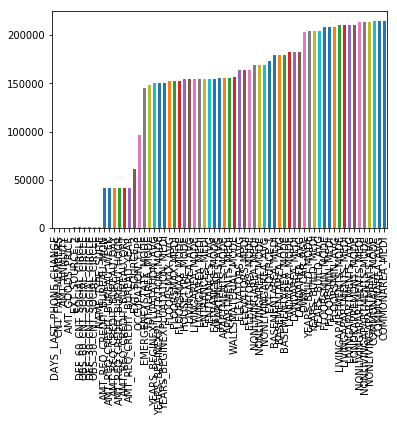

In [445]:
missing = train.isnull().sum()
missing = missing[missing >0]
missing.sort_values(inplace=True)
# missing.plot.bar()

In [446]:
# missing

DAYS_LAST_PHONE_CHANGE               1
CNT_FAM_MEMBERS                      2
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
EXT_SOURCE_2                       660
DEF_60_CNT_SOCIAL_CIRCLE          1021
OBS_60_CNT_SOCIAL_CIRCLE          1021
DEF_30_CNT_SOCIAL_CIRCLE          1021
OBS_30_CNT_SOCIAL_CIRCLE          1021
NAME_TYPE_SUITE                   1292
AMT_REQ_CREDIT_BUREAU_MON        41519
AMT_REQ_CREDIT_BUREAU_WEEK       41519
AMT_REQ_CREDIT_BUREAU_DAY        41519
AMT_REQ_CREDIT_BUREAU_HOUR       41519
AMT_REQ_CREDIT_BUREAU_QRT        41519
AMT_REQ_CREDIT_BUREAU_YEAR       41519
EXT_SOURCE_3                     60965
OCCUPATION_TYPE                  96391
EMERGENCYSTATE_MODE             145755
TOTALAREA_MODE                  148431
YEARS_BEGINEXPLUATATION_AVG     150007
YEARS_BEGINEXPLUATATION_MODE    150007
YEARS_BEGINEXPLUATATION_MEDI    150007
FLOORSMAX_AVG                   153020
FLOORSMAX_MEDI                  153020
FLOORSMAX_MODE           

In [447]:
train = train.drop(columns=['APARTMENTS_MEDI',
                            'BASEMENTAREA_MEDI',
                            'YEARS_BEGINEXPLUATATION_MEDI',
                            'YEARS_BUILD_MEDI',
                            'COMMONAREA_MEDI',
                            'ELEVATORS_MEDI',
                            'ENTRANCES_MEDI',
                            'FLOORSMAX_MEDI',
                            'FLOORSMIN_MEDI',
                            'LANDAREA_MEDI',
                            'LIVINGAPARTMENTS_MEDI',
                            'LIVINGAREA_MEDI',
                            'NONLIVINGAPARTMENTS_MEDI',
                            'NONLIVINGAREA_MEDI',
                            'APARTMENTS_MODE',
                            'BASEMENTAREA_MODE',
                            'YEARS_BEGINEXPLUATATION_MODE',
                            'YEARS_BUILD_MODE',
                            'COMMONAREA_MODE',
                            'ELEVATORS_MODE',
                            'ENTRANCES_MODE',
                            'FLOORSMAX_MODE',
                            'FLOORSMIN_MODE',
                            'LANDAREA_MODE',
                            'LIVINGAPARTMENTS_MODE',
                            'LIVINGAREA_MODE',
                            'NONLIVINGAPARTMENTS_MODE',
                            'NONLIVINGAREA_MODE',
                            'FONDKAPREMONT_MODE',
                            'HOUSETYPE_MODE',
                            'TOTALAREA_MODE',
                            'WALLSMATERIAL_MODE',
                            'EMERGENCYSTATE_MODE'
                            ,
                            'FLAG_DOCUMENT_2',
                            'FLAG_DOCUMENT_3',
                            'FLAG_DOCUMENT_4',
                            'FLAG_DOCUMENT_5',
                            'FLAG_DOCUMENT_6',
                            'FLAG_DOCUMENT_7',
                            'FLAG_DOCUMENT_8',
                            'FLAG_DOCUMENT_9',
                            'FLAG_DOCUMENT_10',
                            'FLAG_DOCUMENT_11',
                            'FLAG_DOCUMENT_12',
                            'FLAG_DOCUMENT_13',
                            'FLAG_DOCUMENT_14',
                            'FLAG_DOCUMENT_15',
                            'FLAG_DOCUMENT_16',
                            'FLAG_DOCUMENT_17',
                            'FLAG_DOCUMENT_18',
                            'FLAG_DOCUMENT_19',
                            'FLAG_DOCUMENT_20',
                            'FLAG_DOCUMENT_21',
                            'FLAG_MOBIL',
                            'FLAG_EMP_PHONE',
                            'FLAG_WORK_PHONE',
                            'FLAG_CONT_MOBILE',
                            'FLAG_PHONE'
                            # ,
                            # 'NAME_TYPE_SUITE',
                            # 'NAME_FAMILY_STATUS'
                            ])

In [448]:
numerical = [f for f in train.columns if train.dtypes[f] != 'object']
numerical.remove('TARGET')
categorical = [f for f in train.columns if train.dtypes[f] == 'object']

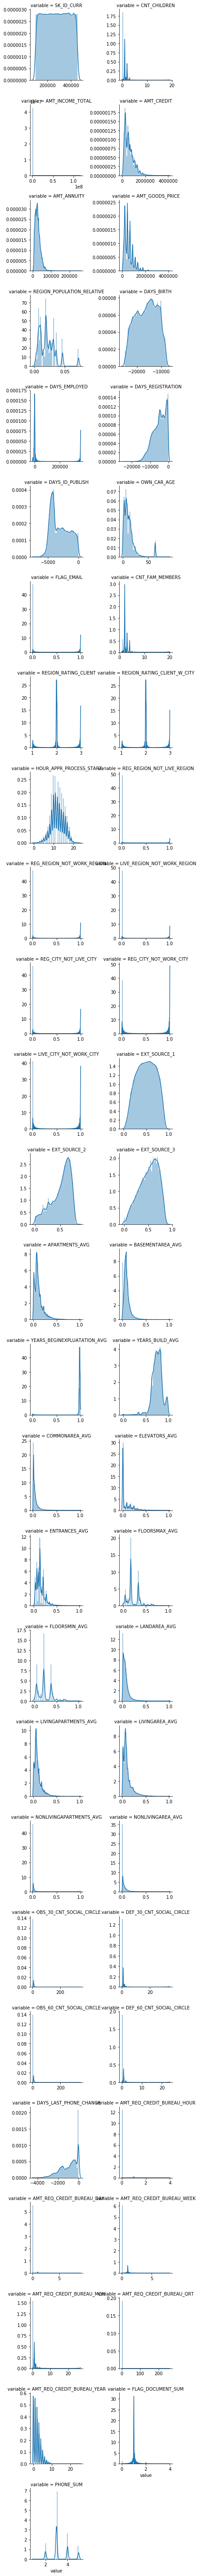

In [450]:
# f = pd.melt(train, value_vars=numerical)
# g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
# g = g.map(sns.distplot, "value")

In [427]:
for c in categorical:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

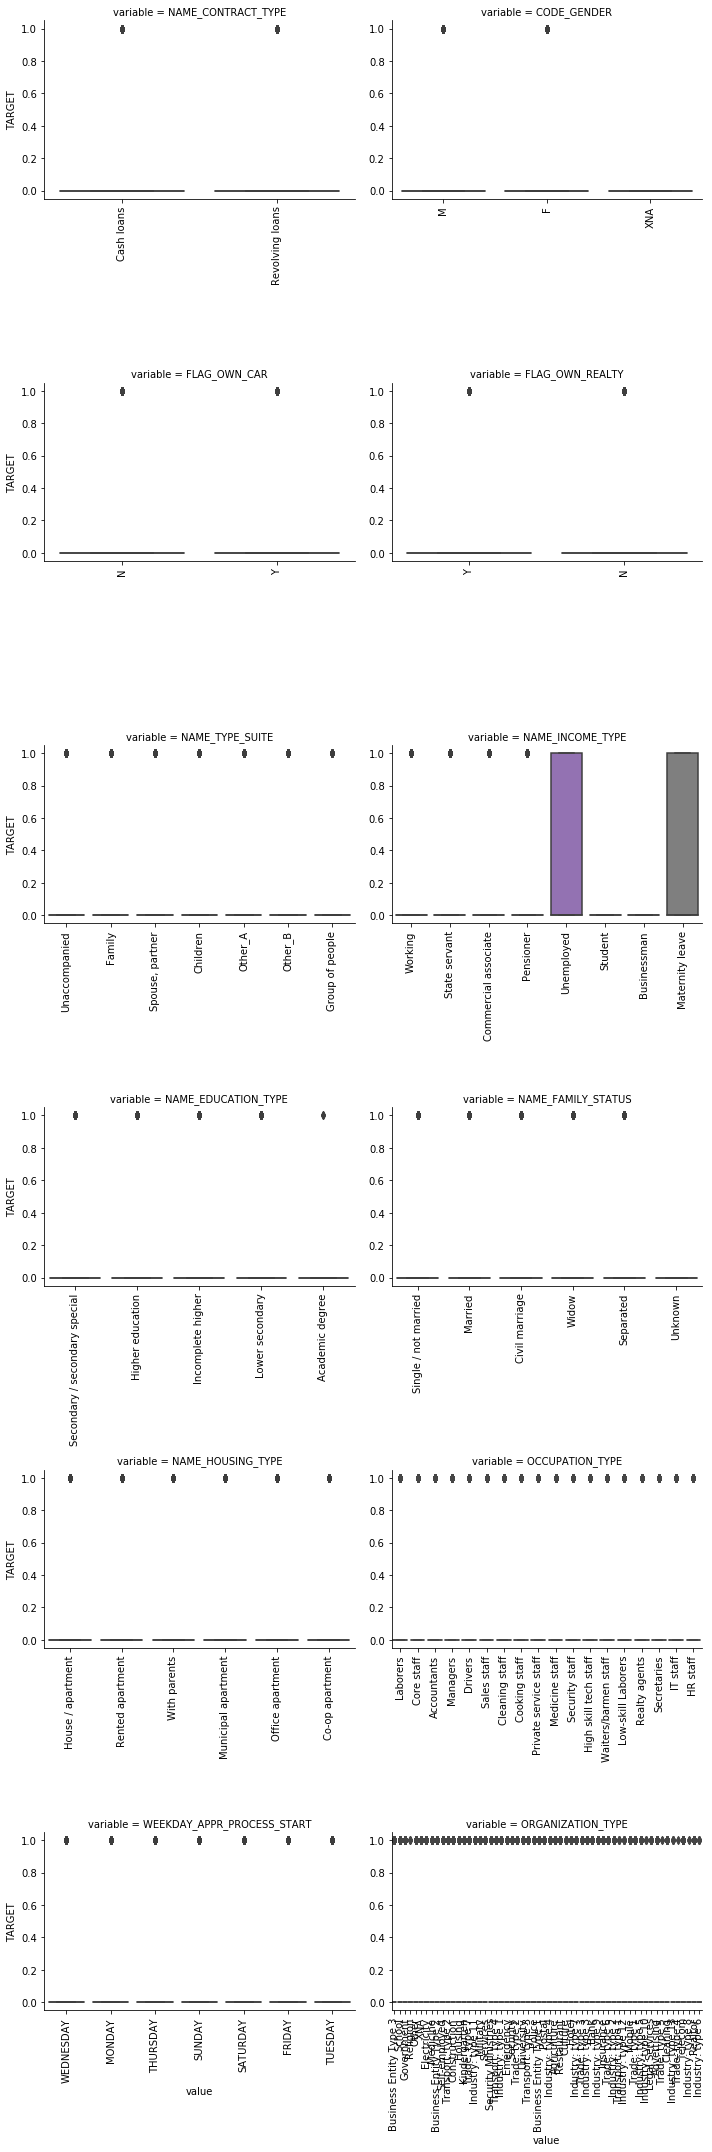

In [451]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
# f = pd.melt(train, id_vars=['TARGET'], value_vars=categorical)
# g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
# g = g.map(boxplot, "value", "TARGET")

In [452]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    # ordering['spmean'] = frame[[feature, 'TARGET']].groupby(feature).mean()['TARGET']
    # ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()

    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

cate_encoded = []
for q in categorical:
    encode(train, q)
    encode(test, q)
    cate_encoded.append(q+'_E')
# print(cate_encoded)

['NAME_CONTRACT_TYPE_E', 'CODE_GENDER_E', 'FLAG_OWN_CAR_E', 'FLAG_OWN_REALTY_E', 'NAME_TYPE_SUITE_E', 'NAME_INCOME_TYPE_E', 'NAME_EDUCATION_TYPE_E', 'NAME_FAMILY_STATUS_E', 'NAME_HOUSING_TYPE_E', 'OCCUPATION_TYPE_E', 'WEEKDAY_APPR_PROCESS_START_E', 'ORGANIZATION_TYPE_E']


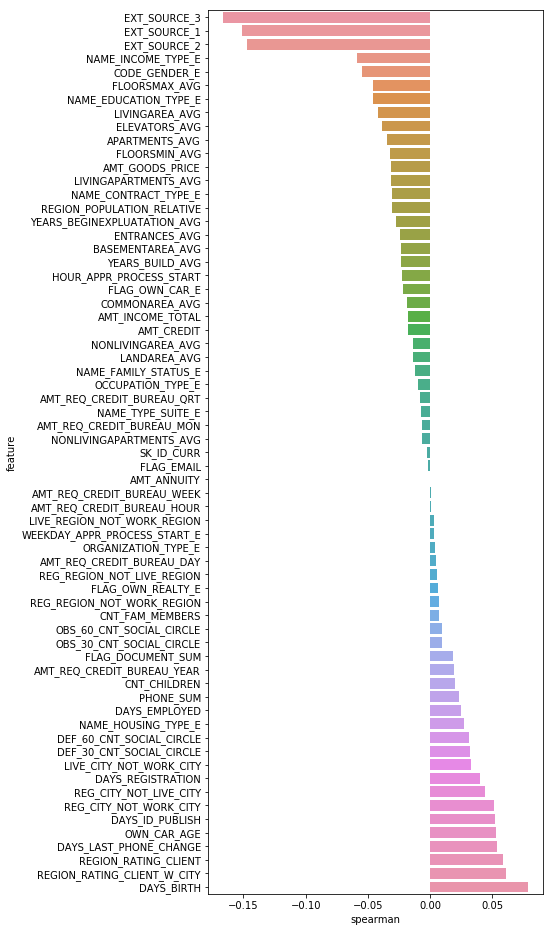

In [453]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['TARGET'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

features = numerical + cate_encoded
# spearman(train, features)

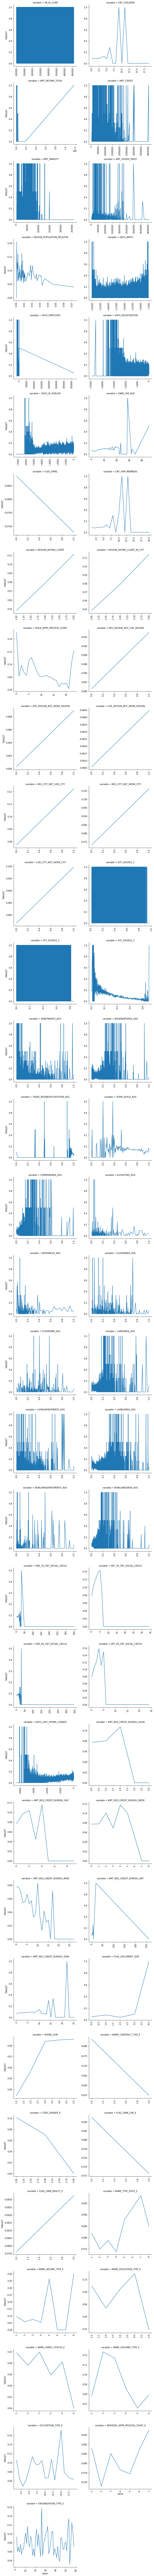

In [455]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)

# f = pd.melt(train, id_vars=['TARGET'], value_vars=numerical+cate_encoded)
# g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
# g = g.map(pairplot, "value", "TARGET")

In [457]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2

In [458]:
log_transform('AMT_CREDIT')
log_transform('AMT_ANNUITY')
log_transform('AMT_GOODS_PRICE')

In [459]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42, )
for train_index, test_index in split.split(train, train["NAME_INCOME_TYPE"]):
    train_set = train.loc[train_index]
    test_set = train.loc[test_index]

In [460]:
features = numerical + cate_encoded
# X_train = train[features].fillna(0.).values
# y_train = train['TARGET'].values
# X_test = test[features].fillna(0.).values


X_train = train_set[features].fillna(0.).values
y_train = train_set['TARGET'].values
X_test = test_set[features].fillna(0.).values
y_test = test_set['TARGET'].values

In [461]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict_proba(X_test)[:,1]

In [462]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred)

0.5946713521254587

In [463]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve

svc = SVC(gamma=.05).fit(X_train, y_train)
y_pred = svc.decision_function(X_test)


In [440]:
roc_auc_score(y_test, y_pred)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2, n_jobs=-1)
y_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

In [439]:
# my_submission = pd.DataFrame({'SK_ID_CURR': test.SK_ID_CURR, 'TARGET': y_pred})
# my_submission.to_csv('submission.csv', index=False)